In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Reading the datasets :
dataset1 = pd.read_csv('data\dataset1.txt')
dataset2 = pd.read_csv('data\dataset2.txt')
dataset3 = pd.read_csv('data\dataset3.txt')

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
C:\Users\eugen\AppData\Local\Temp\ipykernel_1516\4140394424.py:2: SyntaxWarning: invalid escape sequence '\d'
  dataset1 = pd.read_csv('data\dataset1.txt')
C:\Users\eugen\AppData\Local\Temp\ipykernel_1516\4140394424.py:3: SyntaxWarning: invalid escape sequence '\d'
  dataset2 = pd.read_csv('data\dataset2.txt')
C:\Users\eugen\AppData\Local\Temp\ipykernel_1516\4140394424.py:4: SyntaxWarning: invalid escape sequence '\d'
  dataset3 = pd.read_csv('data\dataset3.txt')


<Axes: xlabel='Time'>

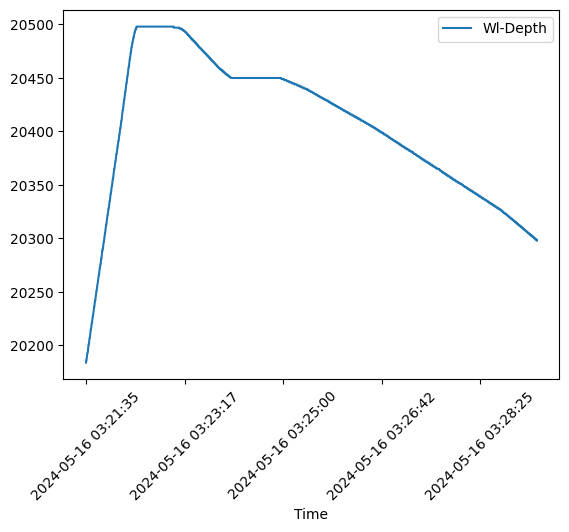

In [732]:
#Ploting each time series
dataset1.plot(x= 'Time', y= time_series_col, rot = 45)

<Axes: xlabel='Time'>

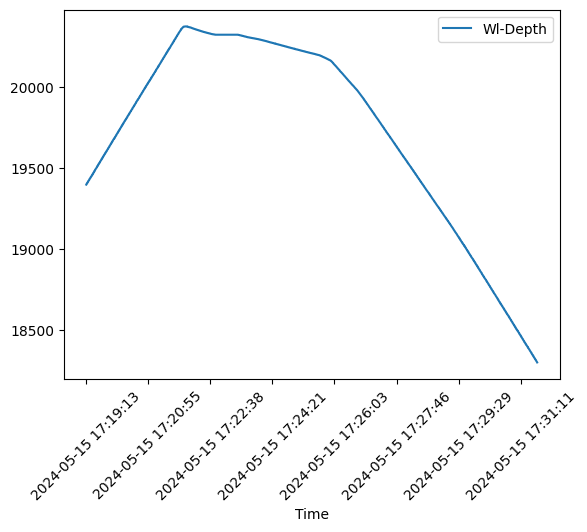

In [733]:
dataset2.plot(x= 'Time', y= time_series_col, rot = 45)

<Axes: xlabel='Time'>

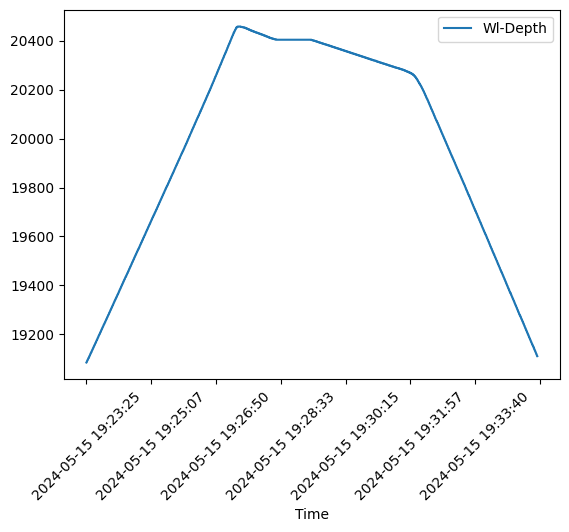

In [734]:
dataset3.plot(x= 'Time', y= 'Wl-Depth', rot = 45)

In [48]:
def get_relevant_points(data, *,
        time_series_col = 'Wl-Depth',
        strictness_level = 0, #Values should range from 1 to 3, if not specified it reverts to default values or value specified by user
        smooth_factor = 0.1,
        smooth_diff_factor = 0.04,
        make_plot = True,   
        display_statistics = False,
        only_return_point_type = True,
        percentile = 0.75,
        rolling_window = 200, 
        group_time_freq = 'T', 
        num_points = 30,
        stationary_slope = 0.01) :
    """ 
        This function recieves a time series from a measurement device
        and gets stationary points and where sudden changes in its rate of change (vertices).
        It plots these points if specified with the nake_plot parameter,
        gives basic statistics according display_statistics parameter
        and returns a dataframe with the relevant points.
     """

    #Defining parameters according to stricness_level
    if strictness_level == 1 :
        percentile = 0.5
        rolling_window = 100
        num_points = 10
        stationary_slope = 0.1
    elif strictness_level == 2 :
        percentile = 0.75
        rolling_window = 200
        num_points = 30
        stationary_slope = 0.01
    elif strictness_level == 3 :
        percentile = 0.9
        rolling_window = 500
        num_points = 50
        stationary_slope = 0.005

    #Reading the data:
    df = pd.read_csv(data)

    #Smoothing the data according to the smooth factor
    df[f'Smooth {smooth_factor}'] = df[time_series_col].ewm(alpha = smooth_factor).mean()

    #Converting time variable to pd.datetime and making a new column for hours in order to make the plot more readable
    df['Time'] = pd.to_datetime(df['Time'])
    df['hour'] = df['Time'].dt.strftime('%H:%M:%S')

    #Getting the first and second differences and smoothing them out according to the smooth_diff_factor paramenter
    df['diff 1'] = [np.nan] + list(np.diff(df[f'Smooth {smooth_factor}']))
    df['diff 1'] = df['diff 1'].ewm(alpha = smooth_diff_factor).mean()
    df['diff 2'] = [np.nan] + list(np.diff(df['diff 1']))
    df['diff 2'] = df['diff 2'].ewm(alpha = smooth_diff_factor).mean()

    #Getting the maximum absolute change in the seccond difference in a rolling window of size rolling_window
    #This will be later be used to find the vertices.
    abs_min = np.abs(df['diff 2'].rolling(window=rolling_window).min())
    abs_max = np.abs(df['diff 2'].rolling(window=rolling_window).max())
    df['big 2 diff'] = [max(minimum,maximum) for minimum,maximum in zip(abs_min,abs_max)]
    df['big 2 diff'] = df['big 2 diff'].fillna(-1)

    #Getting all points where the first difference is less than or equal to the stationary_slope
    #In other words, getting all points where the signal is practically not changing at all
    dfStationary = df[np.abs(df['diff 1']) <= stationary_slope]

    #This might yield multiple points that lie in a similar timestamp.
    #Grouping these points according to time_series_col and Time values of frequency group_time_freq to aggregate thesse points
    # Group by both time_series_col and 'Time'
    grouped = dfStationary.groupby([time_series_col, pd.Grouper(key='Time', freq= group_time_freq)])

    # Initialize a list to store summarized data
    summarized_data = []

    # Iterate over each group
    for name, group in grouped:
        if len(group) <= num_points:
            # If there are less than or equal to num_points, take it as just one stationary point
            stationary = group.iloc[0]
            stationary['Point type'] = 'Stationary point'
            summarized_data.append(stationary)
        else:
            # If there are more than num_points, take both the first and last points as if it where a stationary interval
            stationary_first = group.iloc[0]
            stationary_last = group.iloc[-1]
            stationary_first['Point type'] = 'Stationary begins'
            stationary_last['Point type'] = 'Stationary ends'
            summarized_data.append(stationary_first)
            summarized_data.append(stationary_last)
    dfStationary = pd.DataFrame(summarized_data)
 
    #Finding= points where there is a sudden change in the rate of change (where the second difference is quite large in magnitud)    
    #Here we'll be taking all points that have the big 2 diff value greater than the parameter percentile
    dfBigChanges = df[np.abs(df['diff 2']) >= df['big 2 diff'].quantile(percentile)]
    summarized_data = pd.DataFrame()
    grouper = dfBigChanges.groupby(pd.Grouper(key= 'Time', freq = group_time_freq))
    for name, group in grouper :
        max_change = group['big 2 diff'].max()
        if max_change != -1:
            summarized_data = pd.concat([summarized_data, group[np.abs(group['diff 2']) == max_change].head(1)])
    dfBigChanges = summarized_data
    dfBigChanges['Point type'] = 'Vertex'

    #Putting it all together. Uniting stationary points and vertices into one single dataframe: dfRelevantPoints
    dfRelevantPoints = pd.concat([dfStationary,dfBigChanges])
    #Dropping points that happened at the same time.
    dfRelevantPoints = dfRelevantPoints.drop_duplicates(subset = ['Time'], keep = 'last')
    #Sorting by Time
    dfRelevantPoints = dfRelevantPoints.sort_values(by = 'Time')


    if make_plot :
        x = df['hour']
        y = df[time_series_col]

        x_axis_steps = df.shape[0]//10

        plt.plot(x,y)

        groupedPointType = dfRelevantPoints.groupby('Point type')

        for label, group in groupedPointType :
            plt.scatter(group['hour'], group[time_series_col], label=label)


        plt.xticks(rotation = 45)
        plt.gca().set_xticks(df['hour'][::x_axis_steps])
        plt.legend()
        plt.show()
    if display_statistics : display(df.describe())
    if only_return_point_type : return dfRelevantPoints.drop(columns = ['diff 1', 'diff 2', 'big 2 diff', f'Smooth {smooth_factor}', 'hour'])
    else : return dfRelevantPoints

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\eugen\AppData\Local\Temp\ipykernel_1516\1158396064.py:1: SyntaxWarning: invalid escape sequence '\d'
  df = get_relevant_points('data\dataset1.txt',
C:\Users\eugen\AppData\Local\Temp\ipykernel_1516\3182258975.py:69: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  grouped = dfStationary.groupby([time_series_col, pd.Grouper(key='Time', freq= group_time_freq)])
C:\Users\eugen\AppData\Local\Temp\ipykernel_1516\3182258975.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stationary['Point type'] = 'Stationary point'
C:\Users\eugen\AppData\Local\Temp\ipykernel_1516\3182258975.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy 

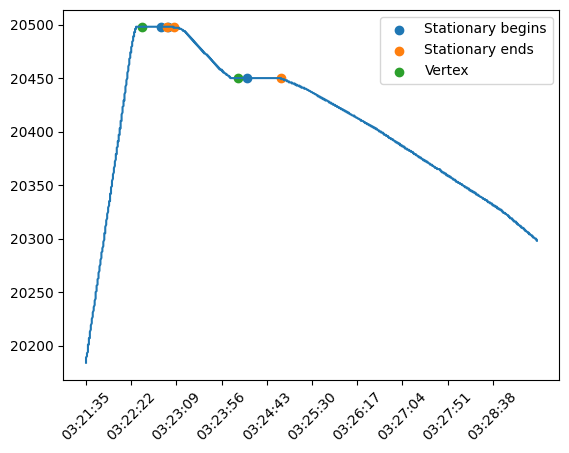

,Time,Wl-ShootingVoltage,Wl-Depth,Wl-ShootingVoltage.1,Point type
285,2024-05-16 03:22:33,-1,20498,-1,Vertex
380,2024-05-16 03:22:53,-1,20498,-1,Stationary begins
413,2024-05-16 03:22:59,-1,20498,-1,Stationary ends
414,2024-05-16 03:23:00,-1,20498,-1,Stationary begins
445,2024-05-16 03:23:06,-1,20498,-1,Stationary ends
770,2024-05-16 03:24:13,-1,20450,-1,Vertex
815,2024-05-16 03:24:22,-79,20450,-79,Stationary begins
991,2024-05-16 03:24:58,-1,20450,-1,Stationary ends


In [51]:
df = get_relevant_points('data\dataset1.txt',
        time_series_col = 'Wl-Depth',
        strictness_level = 2,
        make_plot = True,
        display_statistics = False,
        only_return_point_type = True, 
)
df